<a href="https://colab.research.google.com/github/smithlabcode/ribotricer/blob/master/notebooks/Plotting_ribotricer_profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install git+https://github.com/smithlabcode/ribotricer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/smithlabcode/ribotricer to /tmp/pip-req-build-hzb1gxqa
  Running command git clone -q https://github.com/smithlabcode/ribotricer /tmp/pip-req-build-hzb1gxqa


In [2]:
!wget -c https://www.dropbox.com/s/xr0xsdluuni2b95/ribotricer_test_data_tair10.zip

--2022-09-28 20:53:11--  https://www.dropbox.com/s/xr0xsdluuni2b95/ribotricer_test_data_tair10.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xr0xsdluuni2b95/ribotricer_test_data_tair10.zip [following]
--2022-09-28 20:53:11--  https://www.dropbox.com/s/raw/xr0xsdluuni2b95/ribotricer_test_data_tair10.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfbf0093834dbed7b6d128ed399.dl.dropboxusercontent.com/cd/0/inline/Bt0gWivkcupzujjGEP1XNgtwjnUDusLkl5ZtQ2ScfDbp7L3pehZFEzowwE6LgVVI3KM3w6wtc85OVM7yUmGJ-Pqv0VnkrwyEHjoYJhz25wPNLW5P_NsXvkSHj4yAcg5yCJwgi8Prv7L__ShZjcvS_gtgo4DIYUE4BVXpIwUMRyZqBg/file# [following]
--2022-09-28 20:53:11--  https://ucfbf0093834dbed7b6d128ed399.dl.dropboxusercontent.com/cd/0/inline/Bt0gWivkcupzujjGEP1XNgt

In [3]:
!unzip ribotricer_test_data_tair10.zip

Archive:  ribotricer_test_data_tair10.zip
replace ribotricer_test_data_tair10/bams_unique/SRX219170.bam? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
from collections import Counter
from itertools import cycle
from itertools import islice
import os
import sys
import six
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
__FRAME_COLORS__ = ["#fc8d62", "#66c2a5", "#8da0cb"]

def set_xrotation(ax, degrees):
    """Rotate labels on x-axis.
    Parameters
    ----------
    ax : matplotlib.Axes
         Axes object
    degrees : int
              Rotation degrees
    """
    for i in ax.get_xticklabels():
        i.set_rotation(degrees)


def millify(n):
    """Convert integer to human readable format.
    Parameters
    ----------
    n : int
    Returns
    -------
    millidx : str
              Formatted integer
    """
    if n is None or np.isnan(n):
        return "NaN"
    millnames = ["", " K", " M", " B", " T"]
    # Source: http://stackoverflow.com/a/3155023/756986
    n = float(n)
    millidx = max(
        0,
        min(
            len(millnames) - 1, int(math.floor(0 if n == 0 else math.log10(abs(n)) / 3))
        ),
    )

    return "{:.1f}{}".format(n / 10 ** (3 * millidx), millnames[millidx])



def setup_axis(ax, axis="x", majorticks=5, minorticks=1, xrotation=45, yrotation=0):
    """Setup axes defaults
    Parameters
    ----------
    ax : matplotlib.Axes
    axis : str
           Setup 'x' or 'y' axis
    majorticks : int
                 Length of interval between two major ticks
    minorticks : int
                 Length of interval between two major ticks
    xrotation : int
                Rotate x axis labels by xrotation degrees
    yrotation : int
                Rotate x axis labels by xrotation degrees
    """
    major_locator = MultipleLocator(majorticks)
    major_formatter = FormatStrFormatter("%d")
    minor_locator = MultipleLocator(minorticks)
    if axis == "x":
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_formatter)
        ax.xaxis.set_minor_locator(minor_locator)
    elif axis == "y":
        ax.yaxis.set_major_locator(major_locator)
        ax.yaxis.set_major_formatter(major_formatter)
        ax.yaxis.set_minor_locator(minor_locator)
    elif axis == "both":
        setup_axis(ax, "x", majorticks, minorticks, xrotation, yrotation)
        setup_axis(ax, "y", majorticks, minorticks, xrotation, yrotation)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(which="major", width=2, length=10)
    ax.tick_params(which="minor", width=1, length=6)
    ax.tick_params(axis="x", labelrotation=xrotation)
    ax.tick_params(axis="y", labelrotation=yrotation)



def plot_framewise_counts(
    counts,
    frames_to_plot="all",
    ax=None,
    title=None,
    millify_labels=False,
    position_range=None,
    saveto=None,
    **kwargs
):
    """Plot framewise distribution of reads.
    Parameters
    ----------
    counts : Series
             A series with position as index and value as counts
    frames_to_plot : str or range
                     A comma seaprated list of frames to highlight or a range
    ax : matplotlib.Axes
         Default none
    saveto : str
             Path to save output file to (<filename>.png/<filename>.pdf)
    """
    
    if isinstance(counts, Counter):
        counts = pd.Series(counts)
    if isinstance(frames_to_plot, six.string_types) and frames_to_plot != "all":
        frames_to_plot = list([int(x) for x in frames_to_plot.rstrip().split(",")])
    if isinstance(position_range, six.string_types):
        splitted = list([int(x) for x in position_range.strip().split(":")])
        position_range = list(range(splitted[0], splitted[1] + 1))

    if position_range:
        counts = counts[list(position_range)]
    fig = None
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    if "majorticks" not in kwargs:
        kwargs["majorticks"] = 10
    if "minorticks" not in kwargs:
        kwargs["minorticks"] = 5
    if "xrotation" not in kwargs:
        kwargs["xrotation"] = 90

    setup_axis(ax, **kwargs)
    ax.set_ylabel("Number of reads")

    barlist = ax.bar(counts.index, counts.values)
    barplot_colors = list(islice(cycle(__FRAME_COLORS__), None, len(counts.index)))
    for index, cbar in enumerate(barlist):
        cbar.set_color(barplot_colors[index])
    ax.legend(
        (barlist[0], barlist[1], barlist[2]),
        ("Frame 1", "Frame 2", "Frame 3"),
        bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
        loc=3,
        ncol=3,
        mode="expand",
        borderaxespad=0.0,
    )
    if title:
        ax.set_title(title)
    if millify_labels:
        ax.set_yticklabels(list([millify(x) for x in ax.get_yticks()]))
    
    set_xrotation(ax, kwargs["xrotation"])
    fig.tight_layout()
    if saveto:
        fig.tight_layout()
        fig.savefig(saveto, dpi=DPI)
    return ax

In [6]:
# read results from one of the frames
import pandas as pd
ribotricer_df = pd.read_csv("ribotricer_test_data_tair10/translating_ORFs/SRX219170_translating_ORFs.tsv", sep="\t").set_index("ORF_ID")
ribotricer_df = ribotricer_df.sort_values(by='valid_codons_ratio', ascending=False)
ribotricer_df.head()

,ORF_type,status,phase_score,read_count,length,valid_codons,valid_codons_ratio,read_density,transcript_id,transcript_type,gene_id,gene_name,gene_type,chrom,strand,start_codon,profile
ORF_ID,,,,,,,,,,,,,,,,,
AT4G15610.2_8909332_8909406_75,uORF,translating,0.855545,746,75,25,1.0,29.840000,AT4G15610.2,protein_coding,AT4G15610,AT4G15610,protein_coding,4,+,ATT,"[17, 2, 4, 21, 3, 2, 11, 12, 0, 16, 3, 1, 8, 4..."
AT1G68530.2_25712993_25713052_60,dORF,translating,0.819610,199,60,20,1.0,9.950000,AT1G68530.2,protein_coding,AT1G68530,CUT1,protein_coding,1,-,AGG,"[12, 3, 1, 10, 1, 1, 5, 7, 1, 6, 1, 2, 3, 0, 4..."
AT5G48485.1_19646320_19646625_306,annotated,translating,0.803626,2094,306,102,1.0,20.529412,AT5G48485.1,protein_coding,AT5G48485,DIR1,protein_coding,5,-,ATG,"[9, 0, 4, 0, 0, 1, 1, 1, 4, 6, 5, 6, 0, 0, 1, ..."
AT1G60950.1_22444565_22445008_444,annotated,translating,0.861726,7208,444,148,1.0,48.702703,AT1G60950.1,protein_coding,AT1G60950,FD2,protein_coding,1,+,ATG,"[55, 2, 9, 6, 3, 11, 4, 4, 33, 3, 7, 26, 5, 3,..."
AT1G62660.2_23200187_23200300_114,uORF,translating,0.821548,589,114,38,1.0,15.500000,AT1G62660.2,protein_coding,AT1G62660,BFRUCT3,protein_coding,1,+,ACG,"[2, 7, 2, 1, 10, 0, 0, 30, 3, 1, 15, 2, 1, 14,..."


<AxesSubplot:ylabel='Number of reads'>

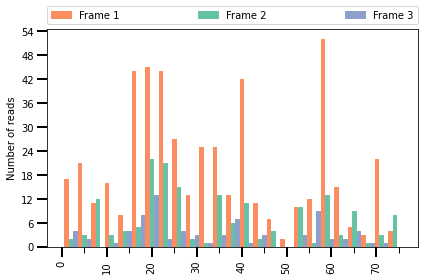

In [7]:
# Load profile from the first uORF
profile = eval(ribotricer_df.loc['AT4G15610.2_8909332_8909406_75', 'profile'])
plot_framewise_counts(pd.Series(profile, index=range(1, len(profile)+1)))